This workbook is the Python implementation of exact GP EI gradients w.r.t. input vector **x** (i.e. GP dEI).

The synthetic (test) function is: *y* = sin(**x**).

GP EI is the Expected Improvement with Gaussian Processes' acquisition function for Bayesian optimization (i.e. BayesOpt).

Requires: 'pyGPGO', a Python (>3.5) package for BayesOpt.

https://pygpgo.readthedocs.io/en/latest/

In [35]:
pip install pyGPGO


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [36]:
### 1. Import python modules/packages required:

import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import warnings
import itertools
import seaborn as sns
import time

from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential
from joblib import Parallel, delayed
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
from scipy.stats import norm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

warnings.filterwarnings("ignore", category=RuntimeWarning)


In [37]:
### 2. Assign user-defined input variables:

n_start_AcqFunc = 10                            # Multiple random-start

n_test = 500                                    # number of prediction observations
eps = 1e-08                                     # numerical stability constant

util_grad_exact = 'dEI_GP'                      # GP EI acquisition function, optimized using exact GP dEI gradients
util_grad_approx = 'ExpectedImprovement'        # GP EI acquisition function, optimized using approx GP EI gradients

n_init = 3                                      # number of random initialisation iterations
iters = 1                                       # number of post-initialisation iterations (will increase incrementally)
opt = True                                      # Hyperparameter-tuning implemented for S.E. kernel parameters x3


In [38]:
### 3. Synthetic function for testing i.e. y = sine(x):

def objfunc(x1_training):                       # Define synthetic function
        return  operator * np.sin(x1_training)

def objfunc_der(x1_training):                   # Define synthetic function's true first-order derivative i.e. gradient
        return  operator * np.cos(x1_training)

# Constraints:
lb = 0                                          # Lower-bound of synthetic function's input x vector (1-D)
ub = 2 * np.pi                                  # Upper-bound of synthetic function's input x vector (1-D)

# Input array dimension(s):                     # 1-D problem
dim = 1

# 1-D inputs' parameter bounds:                 # 1-D bounds' parameter object
param = {'x1_training': ('cont', [lb, ub])}

# True y bounds:
operator = 1                                  # Can toggle between seeking the synthetic's minimum versus maximum
y_global_orig = 1                             # Maximum for y = sine(x)

# Test data:
x1_test = np.linspace(lb, ub, n_test)         # Define test data object
x_test = np.column_stack((x1_test)).T         # Transposed for algebraic reasons

seed = 1                                      # Re-producability term for randomized initialization
cov_func = squaredExponential()               # S.E. kernel class


In [39]:
### 4. Squared-exponential (S.E.) kernel: definition and exact first-order kernel derivative terms

def kronDelta(X, Xstar):                     # Kronecker's Delta method
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):         # S.E. kernel method
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def delta(X, Xstar):                         # Distance between training X and test Xstar vectors
    return (X - Xstar)

def der_covmat(X, Xstar, sigmaf, l, sigman): # Covariance matrix derivative terms (i.e. exact, first-order)
    nx = len(X)
    ny = len(Xstar)
    return np.round(np.array([(delta(np.atleast_2d(i), np.atleast_2d(j))[0] * se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman)[0]).sum() for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)


In [40]:
### 5. Update Gaussian Process (GP) surrogate class, to reflect the S.E. kernel's exact, first-order derivatives:

class dGaussianProcess(GaussianProcess):    # Via inheritance, also optimises hyperparameters when opt = TRUE

    def AcqGrad(self, Xstar):               # Method returning exact, first-order derivatives of the GP's posterior mean and standard deviation
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T

        dKstar = der_covmat(self.X, Xstar, self.covfunc.sigmaf, self.covfunc.l, self.covfunc.sigman).T
        alpha_Kstar = np.dot(np.linalg.inv(self.K + (self.covfunc.sigman**2) * np.eye(len(self.X))), Kstar.T)

        dm = np.dot(dKstar, self.alpha)
        ds = -2 * np.dot(dKstar, alpha_Kstar)

        return dm, ds


In [41]:
### 6. Update Acquisition Function class, to reflect GP EI's exact, first-order derivative terms:

class Acquisition_new(Acquisition):        # Via inheritance
    def __init__(self, mode, eps=eps, **params):

        self.params = params
        self.eps = eps

        mode_dict = {
            'dEI_GP': self.dEI_GP
        }

        self.f = mode_dict[mode]

    def dEI_GP(self, tau, mean, std, ds, dm): # GP EI acquisition function, also returns exact GP EI derivative for each input-dimension
        gamma = (mean - tau - self.eps) / (std + self.eps)
        gamma_h = (mean - tau) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)

        f = (std + self.eps) * (gamma * norm.cdf(gamma) + norm.pdf(gamma))
        df1 = f / (std + self.eps) * dsdx
        df2 = (std + self.eps) * norm.cdf(gamma) * dmdx
        df = df1 + df2

        df_arr = []

        for j in range(0, dim):
          df_arr.append([df])
        return f, np.asarray(df_arr).transpose()

    def d_eval(self, tau, mean, std, ds, dm): # Wrapper function to evaluate dEI_GP

        return self.f(tau, mean, std, ds, dm, **self.params)


In [42]:
### 7. Update Bayesian optimisation classes, to reflect: GP EI's exact derivative, variable multi-starts and start_point_arr attributes:

class dGPGO(GPGO):
    eps = eps

    def acqfunc(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df                      # Returns both GP EI and exact GP EI derivative i.e. GP dEI

    def d_optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfunc,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True, # Requires GP dEI returned as an attribute by self.acqfunc
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])

        self.x_best = x_best
        self.f_best = f_best
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr

        return x_best, f_best, start_points_arr

    def run(self, max_iter=10, init_evals=3, resume=False):

        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self.logger._printInit(self)
        for iteration in range(max_iter):
            self.d_optimizeAcq()            # Requires exact GP EI derivatives returned as an attribute by self.acqfunc
            self.updateGP()
            self.logger._printCurrent(self)

class GPGO_multi(GPGO):

    def _optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):

        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self._acqWrapper,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])

        self.x_best = x_best
        self.f_best = f_best
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr

        return x_best, f_best, start_points_arr

    def run(self, max_iter=10, init_evals=3, resume=False):

        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self.logger._printInit(self)
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self.logger._printCurrent(self)


In [43]:
### 8. Plot synthetic function: plus approximate versus exact gradients for y = sine(x):

def plot_sineApproxGrad(gpgo, param, new=True):
    x_test = np.linspace(lb, ub, n_test).reshape((n_test, 1))
    x_test_h = x_test + eps
    y_hat, y_var = gpgo.GP.predict(x_test, return_std=True)
    std = np.sqrt(y_var)
    l, u = y_hat - 1.96 * std, y_hat + 1.96 * std
    colours = ['Post', 'Random']
    if new:
        plt.figure(figsize=[7,5])
        plt.scatter(gpgo.GP.X, gpgo.GP.y, marker ='D', color = 'Red', label='Post-initialisation point: ($\mathbf{x}$, $y$)')
        plt.scatter(gpgo.X, gpgo.y, marker ='D', color = 'Green', label='Random-initialisation point: ($\mathbf{x}$, $y$)')
        grad = np.array([gpgo.GP.predict(np.atleast_1d(x))[0] for x in x_test]).flatten()
        grad_h = np.array([gpgo.GP.predict(np.atleast_1d(x))[0] for x in x_test_h]).flatten()
        grad = np.array((grad_h - grad)/eps).flatten()
        plt.ylim(-3, 6)
        plt.xlim(0,2 * np.pi)
        plt.plot(x_test.flatten(), operator * objfunc(x_test.flatten()), color = 'Yellow', label='Objective function: $y$ = sin($\mathbf{x}$)')
        plt.plot(x_test.flatten(), y_hat, color = 'Orange', ls = '--', label='GP Posterior mean: $\hat{y} = \mu_{GP}(\mathbf{x})$')
        plt.plot(x_test.flatten(), operator * objfunc_der(x_test.flatten()), color = 'Blue', label='Objective gradient: d$y$/d$\mathbf{x}$ = cos($\mathbf{x}$)')
        plt.plot(x_test, grad, color='Purple', ls = '--', label='GP Posterior mean gradient: d$\hat{y}$/d$\mathbf{x}$ = d$\mu_{GP}(\mathbf{x})$/d$\mathbf{x}$')
        plt.fill_between(x_test.flatten(), l, u, alpha=0.2, label='95% Confidence Interval for $\mu_{GP}(\mathbf{x})$')
        title = 'Sine, GP EI optimised with approximate GP EI gradients'
        plt.title(title, weight = 'bold')
        plt.xlabel("$\mathbf{x}$")
        plt.ylabel("sin($\mathbf{x}$), cos($\mathbf{x}$), $\hat{y}$, d$\hat{y}$/d$\mathbf{x}$")
        plt.legend(loc=0)
        plt.show()

def plot_sineExactGrad(dgpgo, param, new=True):
    x_test = np.linspace(lb, ub, n_test).reshape((n_test, 1))
    y_hat, y_var = dgpgo.GP.predict(x_test, return_std=True)
    std = np.sqrt(y_var)
    l, u = y_hat - 1.96 * std, y_hat + 1.96 * std
    colours = ['Post', 'Random']
    if new:
        plt.figure(figsize=[7,5])
        plt.scatter(dgpgo.GP.X, dgpgo.GP.y, marker ='D', color = 'Red', label='Post-initialisation point: ($\mathbf{x}$, $y$)')
        plt.scatter(dgpgo.X, dgpgo.y, marker ='D', color = 'Green', label='Random-initialisation point: ($\mathbf{x}$, $y$)')
        grad = np.array([dgpgo.GP.AcqGrad(np.atleast_1d(x))[0] for x in x_test]).flatten()
        plt.ylim(-3, 6)
        plt.xlim(0,2 * np.pi)
        plt.plot(x_test.flatten(), operator * objfunc(x_test.flatten()), color = 'Yellow', label='Objective function: $y$ = sin($\mathbf{x}$)')
        plt.plot(x_test.flatten(), y_hat, color = 'Orange', ls = '--', label='GP Posterior mean: $\hat{y} = \mu_{GP}(\mathbf{x})$')
        plt.plot(x_test.flatten(), operator * objfunc_der(x_test.flatten()), color = 'Blue', label='Objective gradient: d$y$/d$\mathbf{x}$ = cos($\mathbf{x}$)')
        plt.plot(x_test, grad, color='Purple', ls = '--', label='GP Posterior mean gradient: d$\hat{y}$/d$\mathbf{x}$ = d$\mu_{GP}(\mathbf{x})$/d$\mathbf{x}$')
        plt.fill_between(x_test.flatten(), l, u, alpha=0.2, label='95% Confidence Interval for $\mu_{GP}(\mathbf{x})$')
        title = 'Sine, GP EI optimised with exact GP dEI gradients'
        plt.title(title, weight = 'bold')
        plt.xlabel("$\mathbf{x}$")
        plt.ylabel("sin($\mathbf{x}$), cos($\mathbf{x}$), $\hat{y}$, d$\hat{y}$/d$\mathbf{x}$")
        plt.legend(loc=0)
        plt.show()


In [44]:
### 9. Combined GP EI acquisition function plots: approximate versus exact GP EI gradients impacting next x (zoomed)

def plot_GP_EI_exactApproxAcqFunc(gpgo, dgpgo, param, new):
    fig, ax = plt.subplots(figsize=[7,5])
    x_test = np.linspace(lb, ub, n_test).reshape((n_test, 1))
    a_exact = np.array([-dgpgo.acqfunc(np.atleast_1d(x))[0] for x in x_test]).flatten()
    a_approx = np.array([-gpgo._acqWrapper(np.atleast_1d(x))[0] for x in x_test]).flatten()
    plt.plot(x_test, a_exact, color='Red', label='GP EI$(\mathbf{x})$')
    plt.ylim(min(a_exact), max(a_exact) + 0.01)
    plt.xlim(0, 2 * np.pi)
    plt.axvline(x=x_test[np.argmax(a_exact)], color='Brown', ls = '-', label='GP EI arg max $\mathbf{x}$: Exact GP dEI gradients')
    plt.axvline(x=x_test[np.argmax(a_approx)], color='Brown', ls = '--', label='GP EI arg max $\mathbf{x}$: Approx GP EI gradients')
    plt.axhline(y=max(a_exact), color='Green', ls = '--', label='$y$ = Maximum GP EI$(\mathbf{x})$')
    plt.legend(loc=1)
    plt.xlabel("$\mathbf{x}$")
    plt.ylabel("GP EI$(\mathbf{x})$")
    title = 'GP EI, optimised with exact GP dEI gradients'
    plt.suptitle(title, weight = 'bold')

    axins = inset_axes(ax, 2, 2, loc=7, bbox_to_anchor=(0.9, 0.45),bbox_transform=ax.figure.transFigure)
    axins.plot(x_test[0:], a_exact[0:], color='r', label='GP EI$(\mathbf{x})$')
    axins.set_ylim(0.1325, 0.1347)
    axins.set_xlim(1.6125, 1.8125) # Limit the region for zoom
    plt.xlabel("$\mathbf{x}$")
    plt.ylabel("GP EI$(\mathbf{x})$")
    axins.set_autoscaley_on(True)
    plt.axvline(x_test[np.argmax(a_exact)][0], color='Brown', ls = '-', label='GP EI arg max $\mathbf{x}$: Exact GP dEI gradients')
    plt.axvline(x_test[np.argmax(a_approx)][0], color='Brown', ls = '--', label='GP EI arg max $\mathbf{x}$: Approx GP EI gradients')
    plt.axhline(y=max(a_exact), color='Green', ls = '--', label='$y$ = Maximum GP EI$(\mathbf{x})$')
    mark_inset(ax, axins, loc1=3, loc2=4, fc="none", ec="0.9")
    plt.draw()
    plt.show()


In [45]:
### 10. Add the respective approximate and exact GP EI gradients to the GP EI plots:

def plot_GP_EI_approxShowGrads(gpgo, param, new):
    fig, ax = plt.subplots(figsize=[7,5])
    x_test = np.linspace(lb, ub, n_test).reshape((n_test, 1))
    x_test_h = x_test + eps
    a = np.array([-gpgo._acqWrapper(np.atleast_1d(x))[0] for x in x_test]).flatten()
    a_h = np.array([-gpgo._acqWrapper(np.atleast_1d(x))[0] for x in x_test_h]).flatten()
    a_grad = np.array((a_h - a)/eps).flatten()
    plt.plot(x_test, a, color='Purple', label='GP EI$(\mathbf{x})$')
    plt.plot(x_test, a_grad, color='Green', ls = '-', label='Approximate GP EI$(\mathbf{x})$ gradients')
    plt.ylim(-0.05 + min(min(a_grad), min(a)), max(max(a_grad), max(a)) + 0.05)
    plt.xlim(0, 2 * np.pi)
    plt.axvline(x=x_test[np.argmax(a)], color='Brown', ls = '--', label='GP EI: arg max $\mathbf{x}$')
    plt.legend(loc=0)
    plt.xlabel("$\mathbf{x}$")
    plt.ylabel("GP EI$(\mathbf{x})$, Approximate GP EI$(\mathbf{x})$ gradients")
    title = 'GP EI, optimised with approximate GP EI gradients'
    plt.suptitle(title, weight = 'bold')
    plt.draw()
    plt.show()
    print('Approx GP EI gradients: GP EI Maximum   ', np.round(max(a), 4))
    print('', )
    print('Approx GP EI gradients: Maximum gradient', np.round(max(a_grad), 4))
    print('Approx GP EI gradients: Minimum gradient', np.round(min(a_grad), 4))

def plot_GP_EI_exactShowGrads(gpgo, param, new):
    fig, ax = plt.subplots(figsize=[7,5])
    x_test = np.linspace(lb, ub, n_test).reshape((n_test, 1))
    a = np.array([-gpgo.acqfunc(np.atleast_1d(x))[0] for x in x_test]).flatten()
    a_grad = np.array([-gpgo.acqfunc(np.atleast_1d(x))[1] for x in x_test]).flatten()
    plt.plot(x_test, a, color='Red', label='GP EI$(\mathbf{x})$')
    plt.plot(x_test, a_grad, color='Blue', ls = '-', label='Exact GP dEI$(\mathbf{x})$ gradients')
    plt.ylim(-0.05 + min(min(a_grad), min(a)), max(max(a_grad), max(a)) + 0.05)
    plt.xlim(0, 2 * np.pi)
    plt.axvline(x=x_test[np.argmax(a)], color='Brown', ls = '-', label='GP EI: arg max $\mathbf{x}$')
    plt.legend(loc=0)
    plt.xlabel("$\mathbf{x}$")
    plt.ylabel("GP EI$(\mathbf{x})$, Exact GP dEI$(\mathbf{x})$ gradients")
    title = 'GP EI, optimised with exact GP dEI gradients'
    plt.suptitle(title, weight = 'bold')
    plt.draw()
    plt.show()
    print('Exact GP dEI gradients: GP EI Maximum   ', np.round(max(a), 4))
    print('', )
    print('Exact GP dEI gradients: Maximum gradient', np.round(max(a_grad), 4))
    print('Exact GP dEI gradients: Minimum gradient', np.round(min(a_grad), 4))


In [46]:
### 11. Approximate versus exact GP EI gradients: Post-initialization iteration 1

np.random.seed(seed)
surrogate_approx_1 = GaussianProcess(cov_func, optimize=opt)
approx_1 = GPGO_multi(surrogate_approx_1, Acquisition(util_grad_approx), objfunc, param)
approx_1.run(init_evals=n_init, max_iter=iters)

np.random.seed(seed)
surrogate_exact_1 = dGaussianProcess(cov_func, optimize=opt)
exact_1 = dGPGO(surrogate_exact_1, Acquisition_new(util_grad_exact), objfunc, param)
exact_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [2.62022653]. 	  0.4980652197092493 	 0.4980652197092493
init   	 [4.52593227]. 	  -0.9826672516685445 	 0.4980652197092493
init   	 [0.00071864]. 	  0.0007186381099970609 	 0.4980652197092493
1      	 [2.62022679]. 	  0.498064996316749 	 0.4980652197092493
Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [2.62022653]. 	  0.4980652197092493 	 0.4980652197092493
init   	 [4.52593227]. 	  -0.9826672516685445 	 0.4980652197092493
init   	 [0.00071864]. 	  0.0007186381099970609 	 0.4980652197092493
1      	 [2.62022585]. 	  0.4980658126604653 	 0.4980658126604653


In [47]:
### 12. Approximate versus exact GP EI gradients: Post-initialization iteration 2

np.random.seed(seed)
surrogate_approx_2 = GaussianProcess(cov_func, optimize=opt)
approx_2 = GPGO_multi(surrogate_approx_2, Acquisition(util_grad_approx), objfunc, param)
approx_2.run(init_evals=n_init, max_iter=iters+1)

np.random.seed(seed)
surrogate_exact_2 = dGaussianProcess(cov_func, optimize=opt)
exact_2 = dGPGO(surrogate_exact_2, Acquisition_new(util_grad_exact), objfunc, param)
exact_2.run(init_evals=n_init, max_iter=iters+1)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [2.62022653]. 	  0.4980652197092493 	 0.4980652197092493
init   	 [4.52593227]. 	  -0.9826672516685445 	 0.4980652197092493
init   	 [0.00071864]. 	  0.0007186381099970609 	 0.4980652197092493
1      	 [2.62022679]. 	  0.498064996316749 	 0.4980652197092493
2      	 [2.30768307]. 	  0.740564204683753 	 0.740564204683753
Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [2.62022653]. 	  0.4980652197092493 	 0.4980652197092493
init   	 [4.52593227]. 	  -0.9826672516685445 	 0.4980652197092493
init   	 [0.00071864]. 	  0.0007186381099970609 	 0.4980652197092493
1      	 [2.62022585]. 	  0.4980658126604653 	 0.4980658126604653
2      	 [2.28710499]. 	  0.7542346135483549 	 0.7542346135483549


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [2.62022653]. 	  0.4980652197092493 	 0.4980652197092493
init   	 [4.52593227]. 	  -0.9826672516685445 	 0.4980652197092493
init   	 [0.00071864]. 	  0.0007186381099970609 	 0.4980652197092493
1      	 [2.62022679]. 	  0.498064996316749 	 0.4980652197092493
2      	 [2.30768307]. 	  0.740564204683753 	 0.740564204683753
3      	 [1.73517114]. 	  0.9865208508399078 	 0.9865208508399078


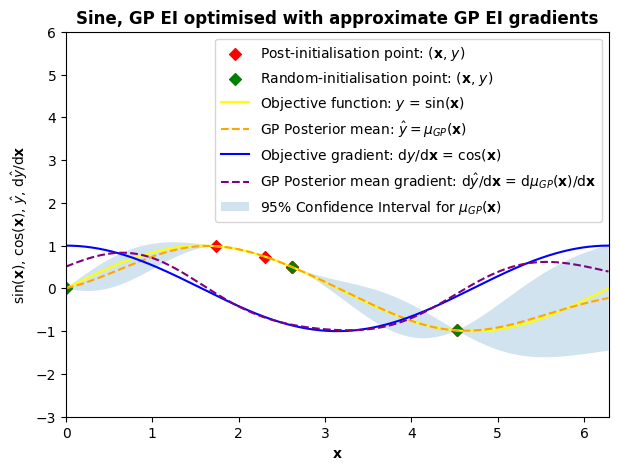

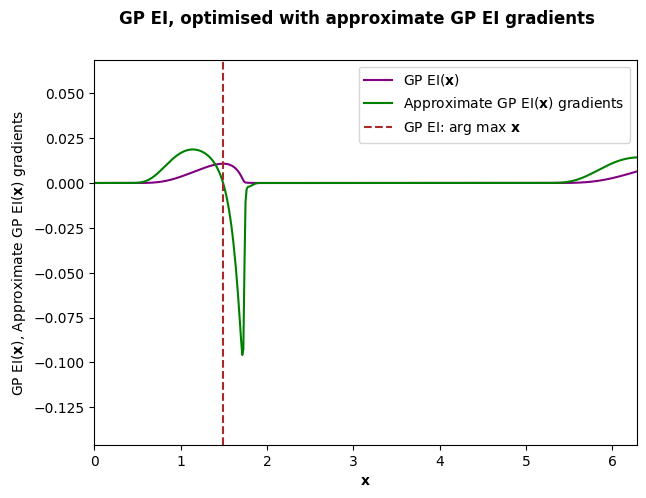

Approx GP EI gradients: GP EI Maximum    0.0108

Approx GP EI gradients: Maximum gradient 0.0187
Approx GP EI gradients: Minimum gradient -0.0958


In [48]:
### 13. Approximate versus exact GP EI gradients: Post-initialization iteration 3

np.random.seed(seed)
surrogate_approx_3 = GaussianProcess(cov_func, optimize=opt)
approx_3 = GPGO_multi(surrogate_approx_3, Acquisition(util_grad_approx), objfunc, param)
approx_3.run(init_evals=n_init, max_iter=iters+2)

plot_sineApproxGrad(approx_3, param, new=True)
plot_GP_EI_approxShowGrads(approx_3, param, new=True)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [2.62022653]. 	  0.4980652197092493 	 0.4980652197092493
init   	 [4.52593227]. 	  -0.9826672516685445 	 0.4980652197092493
init   	 [0.00071864]. 	  0.0007186381099970609 	 0.4980652197092493
1      	 [2.62022585]. 	  0.4980658126604653 	 0.4980658126604653
2      	 [2.28710499]. 	  0.7542346135483549 	 0.7542346135483549
3      	 [1.71910318]. 	  0.9890226806868355 	 0.9890226806868355


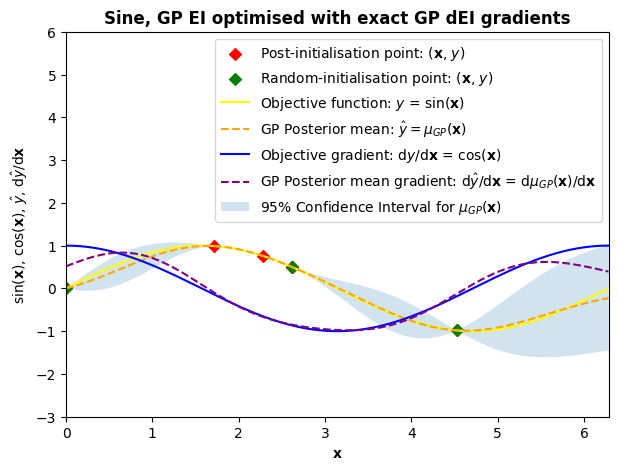

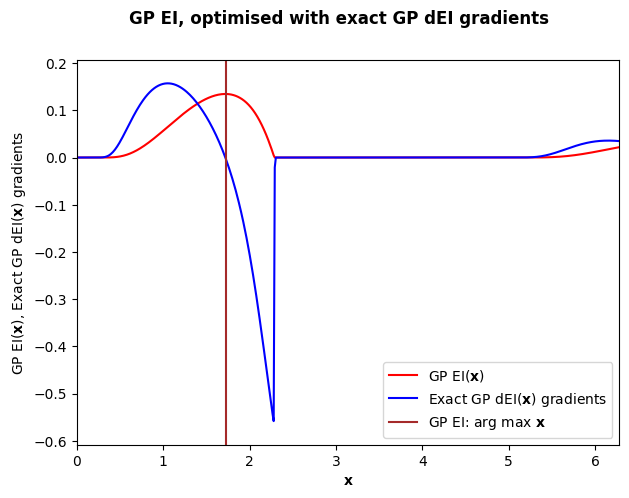

Exact GP dEI gradients: GP EI Maximum    0.1346

Exact GP dEI gradients: Maximum gradient 0.1571
Exact GP dEI gradients: Minimum gradient -0.5581


In [49]:
### 14. Approximate versus exact GP EI gradients: Post-initialisation iteration 3

np.random.seed(seed)
surrogate_exact_3 = dGaussianProcess(cov_func, optimize=opt)
exact_3 = dGPGO(surrogate_exact_3, Acquisition_new(util_grad_exact), objfunc, param)
exact_3.run(init_evals=n_init, max_iter=iters+2)

plot_sineExactGrad(exact_3, param, new=True)
plot_GP_EI_exactShowGrads(exact_2, param, new=True)


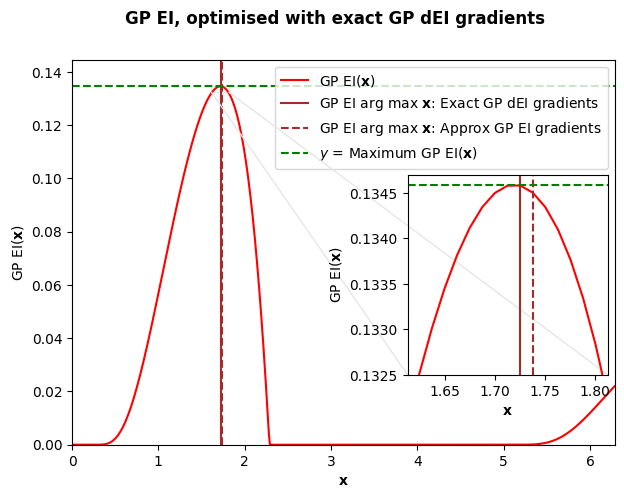

In [50]:
### 15. Combined GP EI plot: approximate versus exact GP EI gradients, compared for x sampling (zoomed)

plot_GP_EI_exactApproxAcqFunc(approx_2, exact_2, param, new=True)


In [51]:
### 16. Approximate versus exact GP EI gradients: Post-initialisation iteration 3

np.random.seed(seed)
surrogate_approx_3 = GaussianProcess(cov_func, optimize=opt)
approx_3 = GPGO_multi(surrogate_approx_3, Acquisition(util_grad_approx), objfunc, param)
approx_3.run(init_evals=n_init, max_iter=iters+2)

np.random.seed(seed)
surrogate_exact_3 = dGaussianProcess(cov_func, optimize=opt)
exact_3 = dGPGO(surrogate_exact_3, Acquisition_new(util_grad_exact), objfunc, param)
exact_3.run(init_evals=n_init, max_iter=iters+2)

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [2.62022653]. 	  0.4980652197092493 	 0.4980652197092493
init   	 [4.52593227]. 	  -0.9826672516685445 	 0.4980652197092493
init   	 [0.00071864]. 	  0.0007186381099970609 	 0.4980652197092493
1      	 [2.62022679]. 	  0.498064996316749 	 0.4980652197092493
2      	 [2.30768307]. 	  0.740564204683753 	 0.740564204683753
3      	 [1.73517114]. 	  0.9865208508399078 	 0.9865208508399078
Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [2.62022653]. 	  0.4980652197092493 	 0.4980652197092493
init   	 [4.52593227]. 	  -0.9826672516685445 	 0.4980652197092493
init   	 [0.00071864]. 	  0.0007186381099970609 	 0.4980652197092493
1      	 [2.62022585]. 	  0.4980658126604653 	 0.4980658126604653
2      	 [2.28710499]. 	  0.7542346135483549 	 0.7542346135483549
3      	 [1.71910318]. 	  0.9890226806868355 	 0.9890226806868355
